In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# import overpy not using, wasn't giving nds, which we need for ordering
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append(f'/media/beans/ssd/bespoke')
sys.path.append(f'/home/beans/bespoke')

from map_utils import *
from big_map_utils import *

In [3]:
%%time

lats, lons, way_ids = get_big_map()

lats.shape, lons.shape, way_ids.shape #TODO stack these three arrays together for better perf later, slight

CPU times: user 407 ms, sys: 24.3 ms, total: 431 ms
Wall time: 673 ms


((24204,), (24204,), (24204,))

CPU times: user 13.8 ms, sys: 7.81 ms, total: 21.6 ms
Wall time: 49.4 ms


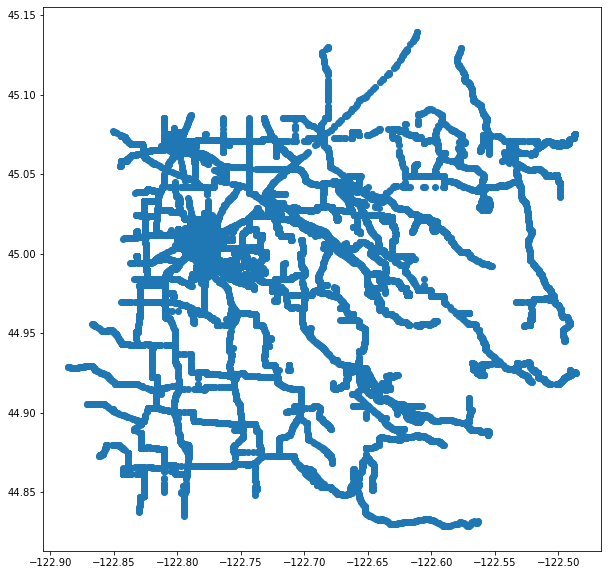

In [4]:
%%time
plt.figure(figsize=(10,10))
plt.scatter(lons, lats)

In [5]:
# Narrowing down to window around vehicle. 
# Everything below will be called every frame, so it should take only a few ms as to not impede on our 50ms modeld loop

#current_lat, current_lon = 44.973490, -122.645679 #nabq curves
current_lat, current_lon = 45.023867, -122.741862 # start sabq
vehicle_heading = .7 + np.pi/2 # need this hardcoded rotater

In [6]:
lats, lons, way_ids = prepare_small_map_nodes(lats, lons, way_ids, current_lat, current_lon, vehicle_heading, CLOSE_BUFFER)
lats.shape, lons.shape, way_ids.shape

((17,), (17,), (17,))

In [7]:
small_map = draw_small_map(lats, lons, way_ids)
small_map.shape

(100, 80, 3)

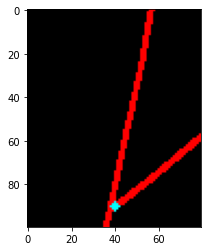

In [8]:
plt.imshow(small_map)